# Библиотеки, функции

### Libraries

In [1]:
try:
    from google.colab import drive
    drive.mount('/content/drive')
    PATH='/content/drive/My Drive/Colab Notebooks/'
except:
    PATH = 'data/'

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [0]:
import warnings
warnings.filterwarnings("ignore")

from os.path import exists
from datetime import date

from fastprogress.fastprogress import master_bar, progress_bar

import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns

from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.feature_selection import SelectFromModel
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, f1_score, roc_auc_score
from sklearn.model_selection import ParameterGrid
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from xgboost import XGBClassifier


RANDOM_STATE = 42
data = None
df = None
features = None

%matplotlib inline

### Functions

In [0]:
SAMPLING = 1.5

def getTypes(df, pr=False):
    ALL = set(df.columns)
    types = df.dtypes
    
    OTH = {'id', 'buy_time', 'binsum', 'prcmean', 'bindb', 'prcdb', 
           'intdb', 'fltdb', 'cluster', 'index', 'vas_id', 'target', 'train'}
    CAT = set(types[types == 'category'].index)
    BIN = set(types[types == 'bool'].index) - OTH
    PRC = set()
    FLT = set() 
    INT = set()
    NUM = ALL - OTH - CAT - BIN
    mbr = progress_bar(NUM)
    for col in mbr:
        t = str(types[col])
        if 'float' in t:
            mx = df[col].max()
            mn = df[col].min()
            if mn>=0 and mx<=1:
                PRC.add(col)
            else:
                FLT.add(col)
        else:
            INT.add(col)

    if pr:
        print(f'TOTAL = {len(ALL)}')
        print(f'  BIN = {len(BIN)}')
        print(f'  CAT = {len(CAT)}')
        print(f'  NUM = {len(NUM)}')
        print(f'    PRC = {len(PRC)}')
        print(f'    FLT = {len(FLT)}')
        print(f'    INT = {len(INT)}')
    return (ALL, OTH, CAT, BIN, PRC, FLT, INT, NUM)

def weekSampling(mnt, tmp, ml=SAMPLING):
    sample = None
    for i in mnt:
        ts = tmp[tmp.index.week == i]
        pr = ts['target'].value_counts()
        mj, mn = pr.index
        lv = pr[mn]
        nn = int(min(round(lv*ml), pr[mj]))
        arr = [
            ts[ts['target']==mn],
            ts[ts['target']==mj].sample(n=nn, random_state=RANDOM_STATE)
        ]

        if sample is not None: arr = [sample] + arr
        sample = pd.concat(arr)
    return sample

def getTrainTest(df, fields, test_size=3, rnd=None, wks=SAMPLING):
    tmp = df.set_index('buy_time').sort_index()
    mnt = tmp.index.week.unique().to_list()
    if rnd: np.random.seed(rnd)
    np.random.shuffle(mnt)
#     test_size = round(len(mnt) * test_size)

    trn = weekSampling(mnt[0:-test_size], tmp, ml=wks)
    tst = tmp[tmp.index.week.isin(mnt[-test_size:])]
    
    return trn[fields], tst[fields], trn['target'], tst['target']

def getSample(df, size=3, rnd=None, wks=SAMPLING):
    tmp = df.set_index('buy_time').sort_index()
    mnt = tmp.index.week.unique().to_list()
    if rnd: np.random.seed(rnd)
    np.random.shuffle(mnt)
    return weekSampling(mnt[0:size], tmp, ml=wks)

def trainModel(model, train, fields):
    tmp = train.set_index('buy_time').sort_index()
    mnt = tmp.index.week.unique().to_list()
    tmp = weekSampling(mnt, tmp)

    return model.fit(tmp[fields], tmp['target'])

def report(md, df, fields):
    X_train, X_test, y_train, y_test = getTrainTest(df, fields)
    
    md.fit(X_train, y_train)
    yp = md.predict_proba(X_test)[:,1]
    ytp = md.predict_proba(X_train)[:,1]
    
    f1 = f1_score(y_test, yp >= 0.5, average='macro')
    r1 = roc_auc_score(y_test, yp)
    r2 = roc_auc_score(y_train, ytp)
    
    print('-'*100)
    print(f'F1 (test) = {f1:0.5f}    roc (test) = {r1:0.5f}   roc (train) = {r2:0.5f}')
    print('-'*100)
    print(classification_report(y_test, yp>=0.5))
    
    import itertools
    from sklearn.metrics import confusion_matrix
    from sklearn.metrics import precision_recall_curve, roc_curve, auc

    ytrue = y_test
    ypred = yp
    
    color = 'r'
    plt.title("Распределение предсказаний модели")
    plt.hist(ypred[~ytrue.astype(bool)], bins=100, color='r', alpha=0.5);
    plt.hist(ypred[ytrue.astype(bool)], bins=100, color='b', alpha=0.5);
    plt.show()
    
    fpr, tpr, roc_thresholds = roc_curve(ytrue, ypred)
    plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % (auc(fpr, tpr)), color=color)
    plt.plot([0, 1], [0, 1], 'k--')
    plt.axis([0.0, 1.0, 0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title("Baseline: AUC_ROC = %.3f" % auc(fpr, tpr))
    plt.legend(loc="lower right")
    plt.show()
    
    cmap=plt.cm.Blues
    classes=["0", "1"]
    th=0.5
    normalize=True
    
    cm = confusion_matrix(y_test, ypred > th)
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest',  cmap=cmap)
    
    plt.grid(False)
    plt.title('Confusion matrix')
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()
    plt.show()

def crossValidate(model, df, fields, splits=3, prnt=None, rnd=None, wks=SAMPLING):
    tmp = df.set_index('buy_time').sort_index()
    mnt = tmp.index.week.unique().to_list()
    if rnd: np.random.seed(rnd)
    np.random.shuffle(mnt)
    f1, f2, r1, r2 = [], [], [], []
    mbr = progress_bar(range(splits), parent=prnt)
    for i in mbr:
        tst = mnt[i*splits:i*splits+splits]
        trn = mnt[0:i*splits] + mnt[i*splits+splits:]
        trn = weekSampling(trn, tmp, ml=wks)
        tst = tmp[tmp.index.week.isin(tst)]
        
        X = trn[fields]
        y_train = trn['target']
        y_test = tst['target']
        
        model.fit(X, y_train)
        yp = model.predict_proba(X)[:, 1]
        yt = model.predict_proba(tst[fields])[:, 1]
        
        f1.append(f1_score(y_train, yp>0.5, average='macro'))
        f2.append(f1_score(y_test, yt>0.5, average='macro'))
        r1.append(roc_auc_score(y_train, yp))
        r2.append(roc_auc_score(y_test, yt))

    f1 = sum(f1) / splits
    f2 = sum(f2) / splits
    r1 = sum(r1) / splits
    r2 = sum(r2) / splits

    if not prnt:
        print(f'{model.__class__.__name__}')
        print(f'  TRAIN: f1 = {f1:0.5f} | roc = {r1:0.5f}')
        print(f'   TEST: f1 = {f2:0.5f} | roc = {r2:0.5f}')
        
    return f1, r2, f2, r2

def gridSeach(model, params_grid, df, fields, cv_splits=1):
    plist = list(ParameterGrid(param_grid))
    mb = master_bar(plist)
    mxf, mxr, bst = 0, 0, {}
    for g in mb:
        model.set_params(**g)
        f1, r2, f2, r2 = crossValidate(model, df, fields, 
                                        splits=cv_splits, prnt=mb, rnd=RANDOM_STATE)
        print(f'f1 = {f2:0.5f} | roc = {r2:0.5f} | PARAMS: {g}')
        if r2>mxr:
            mxf = f2
            mxr = r2
            bst = g
    return mxf, mxr, bst

def gridSelect(param_grid, md, X_train, X_test, y_train, y_test):
    selector = SelectFromModel(md)
    plist = list(ParameterGrid(param_grid))
    mb = progress_bar(plist)
    mxf, mxr, bst = 0, 0, {}
    for g in mb:
        selector.set_params(**g).fit(X_train, y_train)
        nf = X_train.columns[selector.get_support()].to_list()
        Xr = X_train[nf]
        Xt = X_test[nf]

        md.fit(Xr, y_train)
        yp = md.predict_proba(Xt)[:,1]
        ytp = md.predict_proba(Xr)[:,1]

        f1 = f1_score(y_train, ytp >= 0.5, average='macro')
        f2 = f1_score(y_test, yp >= 0.5, average='macro')
        r1 = roc_auc_score(y_train, ytp)
        r2 = roc_auc_score(y_test, yp)

        print(f'f1 = {f2:0.5f} | roc = {r2:0.5f} | roc_train = {r1:0.5f} | PARAMS: {g}')
        if r2>mxr:
            mxf = f2
            mxr = r2
            bst = nf
    return mxf, mxr, bst

def getCorrFeatures(df, fields, size=3, rnd=RANDOM_STATE):
    tmp = getSample(df, size=size, rnd=rnd)
    crr = tmp[set(fields)|{'target'}].corr()['target']
    return set(crr[crr.abs()>0.05].index.to_list()) - {'target'}

In [0]:
def pca_reduce(df, columns=[], rds = [(0.7, 0.15)]):
    rs, rm, bn = set(), set(), set(columns)
    print(f'\nСчитаем корреляцию для {len(bn)} признаков')
    crr = df[bn].corr().abs().unstack()
    
    for ts, pr in rds:
        pr = pr or round(1-ts,2)
        print(f' ... отбираем >= {ts}, уменьщаем на {pr:0.2f}')
        so = crr[crr >= ts]
        a = sorted({x[0]:len(so[x[0]].index.to_list()) for x in so.index}.items(), key=lambda x: x[1], reverse=True)
        a = list(filter(lambda x: x[1]>1, a))
        prog = progress_bar(a)
        for i,k in prog:
            cl = set(so[i].index) & bn
            nf = len(cl)
            if nf < 2: continue
            nf = int(round(nf*pr)) or 1
            if nf == len(cl) and (i not in cl):
                print(f'пропускаем {i} - {cl}')
                continue

            pca = PCA(n_components=nf)
            ss = pca.fit_transform(df[cl])

            print(f'  "{i}-p*"  ({nf})  <=  {cl}')
            for x in range(nf):
                fld = f'{i}-p{x}'
                df[fld] = ss[:, x].astype(float)
                rs.add(fld)
                rm |= cl

            bn -= cl
            df.drop(cl, axis=1, inplace=True)
        print()
    print(f'  добавлено = {len(rs)}, удалено = {len(rm)}, не поменялось = {len(bn)}')
    return rs, rm, bn

In [0]:
def load_data(file, train=True):
    tmp = pd.read_csv(PATH+file, sep=',', index_col=0)
    tmp['buy_time'] = pd.to_datetime( tmp['buy_time'].apply(lambda x: date.fromtimestamp(x)) )
    if not train:
        tmp['target'] = np.NaN
    tmp['train'] = train
    tmp['vas_id'] = tmp['vas_id'].astype(int).astype('category')
    return tmp

def all_data():
    return pd.concat([ load_data('data_train.csv', True), load_data('data_test.csv', False) ]).reset_index()

def updateByQuantile(dd):
    Q1 = dd.quantile(0.20)
    Q3 = dd.quantile(0.80)
    mn = dd.mean()
    IQR = Q3 - Q1
    flt = (dd < (Q1 - 1.5 * IQR)) | (dd > (Q3 + 1.5 * IQR))
    bf = len(dd[flt])
    dd[flt] = mn
    return bf

def plotcorr(corr, w=20, h=15):
    f, ax = plt.subplots(figsize=(w, h))
    sns.heatmap(corr,
                vmin=-1, vmax=1, center=0,
                cmap=sns.diverging_palette(0, 200, n=100),
                square=True)

### Step 1

In [0]:
def step1(df):
    log = open(PATH+'step1.log', 'w')
    start_mem_usg = df.memory_usage().sum() / 1024**2 
    print(f"Использование памяти до преобразований: {start_mem_usg:0.3f} MB")

    mbr = progress_bar(df.columns.drop(['id', 'buy_time']))

    df.index = df.index.astype(np.uint64)
    df['id'] = df['id'].astype(np.uint32)
    df['buy_time'] = pd.to_datetime( df['buy_time'].apply(lambda x: date.fromtimestamp(x)) )

    def convertToInt(values):
        values = values.astype(int)
        mn = values.min()
        mx = values.max()
        dt = int

        if mn >= 0:
            if mx < 255: dt = np.uint8
            elif mx < 65535: dt = np.uint16
            else: dt = np.uint32
        else:
            if mn > np.iinfo(np.int8).min and mx < np.iinfo(np.int8).max:
                dt = np.int8
            elif mn > np.iinfo(np.int16).min and mx < np.iinfo(np.int16).max:
                dt = np.int16

        values = values.astype(dt)
        print(f'    содержит целые числа - конвертируем в {values.dtype} type', file=log)
        return values 

    for col in mbr:
        if not np.isfinite(df[col]).all():
            print(f"ВНИМАНИЕ {col} содержит пустые значения заполняем медианой", file=log)
            df[col].fillna(df[col].median(), inplace=True)

        print(f"обработка признака {col}:", file=log)

        if df[col].nunique() > 2:
            cn = updateByQuantile(df[col])
            print(f"    удаляем {cn} выбросов", file=log)

        mn = df[col].min()
        vc = df[col].value_counts(normalize=True)
        nu = len(vc)

        if vc.values[0] >= 0.999 or nu < 3:
            if nu == 1:
                print(f"    содержит одинаковые значения {mn:0.5f} - удаляем", file=log)
            elif nu == 2:
                bn = f'{col}_bin'
                df[bn] = np.round(df[col] + abs(mn)).astype(bool)
                print(f"    содержит только 2 уникальных значения - создадим {bn} бинарный признак а этот удалим", file=log)
            else:
                vmx = vc.index[0]
                bn = f'{col}_bin'
                df[bn] = (df[col] != vmx).astype(bool)
                print(f"    более 99.9% значений = {vmx:0.5f} - создадим {bn} бинарный признак а этот удалим", file=log)

            df.drop(col, axis=1, inplace=True)
            continue


        asint = df[col].astype(int)
        result = (df[col] - asint).sum()
        if result == 0:
            df[col] = convertToInt(df[col].round())
            continue

        rnd = np.round(df[col] - asint, 6).value_counts(normalize=True)
        rnln = len(rnd)
        if rnln < 3:
            if rnln == 2:
                bn = f'{col}_mj'
                print(f"    скорее всего содержит привязку к категории внутри - добавим {bn} бинарный признак", file=log)
                df[bn] = (df[col] != rnd.index[0]).astype(bool)

            df[col] = convertToInt(df[col].round())
            mn = df[col].min()
            nu = len(df[col].value_counts())

        if nu < 1000:
            print(f"    возможно категория - уникальных значений {nu} - проверяем ... ", end='', file=log)
            tmp = df[col] + abs(mn)

            if tmp.min() >= 0 and tmp.max() <= 1:
                print("пропускаем - скорее всего категория преобразована в проценты от 0 до 1", file=log)
                df[col] = tmp
                continue

            tmp = tmp.round().astype(int)
            vc = tmp.value_counts(normalize=True)
            if len(vc) < 20:
                print(f'преобразуем в категорию', file=log)
                df[col] = tmp.astype('category')
                continue

            vc = np.round(vc,4)
            if len(vc) < 200:
                bn = f'{col}_prc'
                print(f'добавим {bn} процентный признак', file=log)
                df[bn] = tmp.map(dict(vc)).astype(float)
                continue
            else:
                print('не найдено, оставляем как есть', file=log)
                continue

        print(f"    пропускаем", file=log)

    print('====== чистим дубликаты')
    cnt = df['id'].count()
    clm = df.columns.drop('buy_time')
    df.drop_duplicates(['id', 'buy_time'], inplace=True)
    zero = df[df['id']==0].index
    df.drop(zero, inplace=True)

    print(f'  удалено {cnt - df["id"].count()} дубликтатов и {len(zero)} неверных значений')

    mem_usg = df.memory_usage().sum() / 1024**2 
    print(f"Использование памяти ПОСЛЕ преобразований: {mem_usg:0.3f} MB,"
          f"итоговое сжатие {100-100*mem_usg/start_mem_usg:0.2f}% ")
    log.close()

### Step 2

In [0]:
def step2(df):
    (ALL, OTH, CAT, BIN, PRC, FLT, INT, NUM) = getTypes(df, True)
 
    if CAT:
        print(f'Добавляем процентые признаки для {len(CAT)} категориальных признаков')
        mbr = progress_bar(CAT)
        for col in mbr:
            bn = f'{col}_prc'
            t = (features[col].astype(np.uint16) + 1)
            vc = np.round(t.value_counts(normalize=True), 4)
            df[bn] = t.map(dict(vc))
            PRC.add(bn)

        print(f'Добавляем бинарные признаки для {len(CAT)} категориальных признаков')
        tmp = pd.get_dummies(df[CAT], dtype=bool)
        BIN = BIN | set(tmp.columns)
        df.drop(CAT, axis=1, inplace=True)
        mbr = progress_bar(tmp.columns)
        for i in mbr:
            df[i] = tmp[i]
        
    print(f'Добавляем сумму {len(BIN)} бинарных признаков')
    df['binsum'] = df[BIN].sum(axis=1)

    print(f'Добавляем среднее {len(PRC)} процентных признаков')
    df['prcmean'] = df[PRC].mean(axis=1)

    print(f'Уменьшаем размерность {len(BIN)} бинарных признаков')
    _, rm, nt1 = pca_reduce(df, BIN)
    BIN -= rm
    
    print(f'Уменьшаем размерность {len(PRC)} процентных признаков')
    _, rm, nt2 = pca_reduce(df, PRC)
    PRC -= rm
    
    print(f'Уменьшаем размерность {len(INT)} целых признаков')
    _, rm, nt3 = pca_reduce(df, INT)
    
    print(f'Уменьшаем размерность {len(FLT)} вещественных признаков')
    _, rm, nt4 = pca_reduce(df, FLT)

    last = list(nt1 | nt2 | nt3 | nt4)
    print(f'Уменьшаем размерность пересечений {len(last)} признаков')
    for i in range(0, len(last), 50):
        fld = last[i:i+50]
        pca_reduce(df, fld)

    (ALL, OTH, CAT, BIN, PRC, FLT, INT, NUM) = getTypes(df,True)


# Подготовка признаков и данных

## Шаг 1. Загрузка cырых данных и пред-обработка

In [13]:
if not exists(PATH+'step1.pkl.gz'):
    features = None
    print('Читаем исходный файл features.csv.gz')
    features = pd.read_csv(PATH+'features.csv.gz', dtype='float', sep='\t', index_col=0, compression='gzip')
    step1(features)
    print('------------------------------------')
    print('Cохраняем предобработку в файл step1.pkl.gz')
    features.to_pickle(PATH+'step1.pkl.gz', compression='gzip')

print('------------------------------------')
print('Шаг 1 завершен, лог можно посмотреть в step1.log')

Читаем исходный файл features.csv.gz
Использование памяти до преобразований: 8813.531 MB


====== чистим дубликаты
  удалено 1 дубликтатов и 1 неверных значений
Использование памяти ПОСЛЕ преобразований: 4458.414 MB,итоговое сжатие 49.41% 
------------------------------------
Cохраняем предобработку в файл step1.pkl.gz
------------------------------------
Шаг 1 завершен, лог можно посмотреть в step1.log


## Шаг 2. Поиск и удаление зависимостей

In [25]:
if not exists(PATH+'step2.pkl.gz'):
    features = None
    print('Читаем предобработанный файл')
    features = pd.read_pickle(PATH+'step1.pkl.gz', compression='gzip')
    step2(features)
    print('------------------------------------')
    print('Cохраняем предобработку в файл step2.pkl.gz')
    features.to_pickle(PATH+'step2.pkl.gz', compression='gzip')
print('------------------------------------')
print('Шаг 2 завершен')

Читаем предобработанный файл


TOTAL = 276
  BIN = 142
  CAT = 23
  NUM = 109
    PRC = 37
    FLT = 66
    INT = 6
Добавляем процентые признаки для 23 категориальных признаков


Добавляем бинарные признаки для 23 категориальных признаков


Добавляем сумму 325 бинарных признаков
Добавляем среднее 60 процентных признаков
Уменьшаем размерность 325 бинарных признаков

Считаем корреляцию для 325 признаков
 ... отбираем >= 0.7, уменьщаем на 0.15


  "156_bin-p*"  (1)  <=  {'46_bin', '184_bin', '181_bin', '182_bin', '41_bin', '156_bin', '125_bin', '123_bin'}
  "209_0-p*"  (1)  <=  {'209_1', '209_0', '219_1', '217_1', '219_0', '217_0'}
  "73_bin-p*"  (1)  <=  {'10_bin', '12_bin', '71_bin', '73_bin', '74_bin', '72_bin'}
  "125_bin-p*"  (1)  <=  {'42_bin', '124_bin'}
  "136_0-p*"  (1)  <=  {'136_3', '137_bin', '136_0', '135_bin'}
  "76_0-p*"  (1)  <=  {'76_3', '76_0', '104_0', '19_3'}
  "28_0-p*"  (1)  <=  {'28_1', '28_0', '29_1', '29_0'}
  "76_3-p*"  (1)  <=  {'19_6', '104_3'}
  "147_2-p*"  (1)  <=  {'162_2', '147_2', '54_2'}
  "147_7-p*"  (1)  <=  {'162_7', '147_7', '54_7'}
  "147_0-p*"  (1)  <=  {'54_0', '162_0', '147_0'}
  "19_7-p*"  (1)  <=  {'76_4', '19_7', '104_4'}
  "147_6-p*"  (1)  <=  {'162_6', '147_6', '54_6'}
  "104_2-p*"  (1)  <=  {'19_5', '76_2', '104_2'}
  "162_1-p*"  (1)  <=  {'147_1', '162_1', '54_1'}
  "205_bin-p*"  (1)  <=  {'205_bin', '198_bin', '192_bin'}
  "209_2-p*"  (1)  <=  {'217_2', '209_2', '219_2'}
  "252

  "185_prc-p*"  (1)  <=  {'185_prc', '187_prc', '129_prc', '169_prc', '111_prc', '130_prc', '61', '167_prc'}
  "167_prc-p*"  (1)  <=  {'165_prc', '146_prc'}
  "147_prc-p*"  (1)  <=  {'162_prc', '54_prc', '147_prc'}
  "19_prc-p*"  (1)  <=  {'19_prc', '76_prc', '104_prc'}
  "209_prc-p*"  (1)  <=  {'217_prc', '209_prc', '219_prc'}
  "50_prc-p*"  (1)  <=  {'151_prc', '50_prc', '51_prc'}
  "60-p*"  (1)  <=  {'63', '60'}
  "29_prc-p*"  (1)  <=  {'29_prc', '28_prc'}
  "234_prc-p*"  (1)  <=  {'234_prc', '230_prc'}

  добавлено = 9, удалено = 28, не поменялось = 32
Уменьшаем размерность 6 целых признаков

Считаем корреляцию для 6 признаков
 ... отбираем >= 0.7, уменьщаем на 0.15

  добавлено = 0, удалено = 0, не поменялось = 6
Уменьшаем размерность 66 вещественных признаков

Считаем корреляцию для 66 признаков
 ... отбираем >= 0.7, уменьщаем на 0.15


  "51-p*"  (1)  <=  {'151', '52', '146', '50', '53', '51'}
  "169-p*"  (1)  <=  {'169', '165', '130', '171', '185'}
  "43-p*"  (1)  <=  {'170', '44', '186', '45', '43'}
  "185-p*"  (1)  <=  {'187', '167'}
  "0-p*"  (1)  <=  {'2', '0', '4', '14'}
  "3-p*"  (1)  <=  {'3', '5', '1'}
  "38-p*"  (1)  <=  {'117', '38', '116'}
  "144-p*"  (1)  <=  {'144', '143'}
  "112-p*"  (1)  <=  {'39', '112'}
  "234-p*"  (1)  <=  {'230', '234'}
  "113-p*"  (1)  <=  {'113', '40'}
  "243-p*"  (1)  <=  {'243', '244'}
  "7-p*"  (1)  <=  {'7', '49'}

  добавлено = 13, удалено = 40, не поменялось = 26
Уменьшаем размерность пересечений 281 признаков

Считаем корреляцию для 50 признаков
 ... отбираем >= 0.7, уменьщаем на 0.15

  добавлено = 0, удалено = 0, не поменялось = 50

Считаем корреляцию для 50 признаков
 ... отбираем >= 0.7, уменьщаем на 0.15

  добавлено = 0, удалено = 0, не поменялось = 50

Считаем корреляцию для 50 признаков
 ... отбираем >= 0.7, уменьщаем на 0.15


  "59_prc-p*"  (1)  <=  {'59_prc', '59_1'}

  добавлено = 1, удалено = 2, не поменялось = 48

Считаем корреляцию для 50 признаков
 ... отбираем >= 0.7, уменьщаем на 0.15


  "193_1-p*"  (1)  <=  {'193_1', '193_prc'}

  добавлено = 1, удалено = 2, не поменялось = 48

Считаем корреляцию для 50 признаков
 ... отбираем >= 0.7, уменьщаем на 0.15

  добавлено = 0, удалено = 0, не поменялось = 50

Считаем корреляцию для 31 признаков
 ... отбираем >= 0.7, уменьщаем на 0.15

  добавлено = 0, удалено = 0, не поменялось = 31


TOTAL = 343
  BIN = 215
  CAT = 0
  NUM = 124
    PRC = 30
    FLT = 88
    INT = 6
------------------------------------
Cохраняем предобработку в файл step2.pkl.gz
------------------------------------
Шаг 2 завершен


## Шаг 3. Подготовим итоговые данные из наших наборов

In [43]:
if not exists(PATH+'data.pkl.gz'):
    features = None
    print('Читаем предобработанный файл шага 2')
    df = pd.read_pickle(PATH+'step2.pkl.gz', compression='gzip')
    (ALL, OTH, CAT, BIN, PRC, FLT, INT, NUM) = getTypes(df, True)

    fld = ['id', 'buy_time']    
    print('Загружаем рабочие данные ... ', end='')
    data = all_data()
    print(f'{len(data)} записей')

    print('Поиск отсуствующих данных ... ', end='')
    mrg = data[fld].merge(df[fld+['binsum']], how='left', on=fld)
    nf = mrg[mrg.binsum.isnull()][fld]
    fn = mrg[~mrg.binsum.isnull()]['id'].unique()
    print(f'{len(nf)} записей')

    print('Подготовка средних')
    bt = df.groupby('buy_time').mean().drop('id', axis=1)
    us = df[df['id'].isin(nf['id'])].groupby('id').mean()

    print('Поиск средних')
    ad = pd.concat([
      nf.merge(bt, how='left', on='buy_time')[df.columns],
      nf.merge(us, how='left', on='id')[df.columns]
    ]).groupby(fld).mean()

    ad.reset_index(inplace=True)
    ad = ad[df.columns]

    print('Соединяем данные')
    df = df[df['id'].isin(fn)].append(ad[df.columns]).reset_index(drop=True)
    data = data.merge(df, how='left', on=['id', 'buy_time'])
    del features, df, ad, nf, bt, us, mrg

    print('Добавим кластеры для бинарных признаков')
    kmp = {'n_clusters': 5, 'random_state': 42, 
           'precompute_distances': False, 'n_jobs': -1}
    data['bindb'] = KMeans(**kmp).fit_predict(data[BIN])
    data['bindb'] = data['bindb'].astype('category')

    print('Добавим кластеры для процентных признаков')
    data['prcdb'] = KMeans(**kmp).fit_predict(data[PRC])
    data['prcdb'] = data['prcdb'].astype('category')

    print('Добавим кластеры для целых признаков')
    data['intdb'] = KMeans(**kmp).fit_predict(data[INT])
    data['intdb'] = data['intdb'].astype('category')

    print('Добавим кластеры для вещественных признаков')
    data['fltdb'] = KMeans(**kmp).fit_predict(data[FLT])
    data['fltdb'] = data['fltdb'].astype('category')


    print('Уменьшим размерность числовых признаков')
    (ALL, OTH, CAT, BIN, PRC, FLT, INT, NUM) = getTypes(data)
    _ = pca_reduce(data, NUM)
    (ALL, OTH, CAT, BIN, PRC, FLT, INT, NUM) = getTypes(df)


    print('Удалим лишние числовые признаки')
    df = data
    for col in progress_bar(NUM):
        if not np.isfinite(df[col]).all():
            df[col].fillna(df[col].median(), inplace=True)

        if df[col].nunique() > 2:
            Q1, Q3 = df[col].quantile(0.20), df[col].quantile(0.80)
            mn = df[col].mean()
            IQR = Q3 - Q1
            flt = (df[col] < (Q1 - 1.5 * IQR)) | (df[col] > (Q3 + 1.5 * IQR))
            bf = len(df[flt])
            nf = len(df[~flt])

            if bf>0 and bf/(nf+bf) <= 0.05:
                df.loc[flt, col] = mn

        mn = df[col].min()
        vc = df[col].value_counts(normalize=True)
        nu = len(vc)

        if vc.values[0] >= 0.999 or nu < 3:
            if nu == 2:
                df[f'{col}_bin'] = np.round(df[col] + abs(mn)).astype(bool)
            else:
                vmx = vc.index[0]
                bn = f'{col}_bin'
                df[f'{col}_bin'] = (df[col] != vmx).astype(bool)
            df.drop(col, axis=1, inplace=True)
            continue

        if nu < 10:
            tmp = df[col] + abs(mn)
            tmp = tmp.round().astype(int)
            df[col] = tmp.astype('category')

    print('------------------------------------')
    print('Cохраняем итоговые данные в файл data.pkl.gz')
    data.to_pickle(PATH+'data.pkl.gz', compression='gzip')

print('------------------------------------')
print('Шаг 3 завершен')

------------------------------------
Шаг 3 завершен


# Подготовка Train/Test

In [8]:
if df is None:
    print('Читаем данные для работы')
    df = pd.read_pickle(PATH+'data.pkl.gz', compression='gzip')

(ALL, OTH, CAT, BIN, PRC, FLT, INT, NUM) = getTypes(df, True)

print('Добавляем категории')
df = pd.get_dummies(df, columns=CAT, dtype=bool)

TRAIN = df[df['train']]
TEST  = df[~df['train']]

print('Скейлим признаки')
scale = list(FLT|INT)
sc = StandardScaler()
TRAIN.loc[:, scale] = sc.fit_transform(TRAIN[scale])
TEST.loc[:, scale] = sc.transform(TEST[scale])

print('Готово')
(ALL, OTH, CAT, BIN, PRC, FLT, INT, NUM) = getTypes(df, True)
FIELDS = list(NUM|BIN)

Читаем данные для работы


TOTAL = 345
  BIN = 99
  CAT = 0
  NUM = 239
    PRC = 150
    FLT = 89
    INT = 0
Добавляем категории
Скейлим признаки
Готово


TOTAL = 345
  BIN = 99
  CAT = 0
  NUM = 239
    PRC = 150
    FLT = 89
    INT = 0


# Отбор признаков

In [9]:
print('Выбор признаков с помощью оценки корреляции > 0.05 ...', end='')
CORR = getCorrFeatures(TRAIN, FIELDS)
print(f' найдено {len(CORR)}')
print(CORR)

print('Выбор признаков с помощью SelectFromModel ...')
X_train, X_test, y_train, y_test = getTrainTest(TRAIN, FIELDS, wks=2, rnd=RANDOM_STATE)
md = LogisticRegression(solver='liblinear', tol=1e-1, max_iter=20, penalty='l1', 
                        random_state=RANDOM_STATE)
_,_, SMODEL = gridSelect({"threshold": [1e-5, 'median', 'mean']}, 
                     md, X_train, X_test, y_train, y_test)
print(f'SelectModel - отобрано {len(SMODEL)} признаков')


NFIELDS = set(SMODEL) | set(CORR)
print('Выбраны признаки:\n', '-'*100)
print(NFIELDS)
print('-'*100)

Выбор признаков с помощью оценки корреляции > 0.05 ... найдено 7
{'vas_id_2', 'vas_id_8', 'vas_id_6', 'vas_id_1', 'vas_id_4', 'vas_id_5', 'vas_id_7'}
Выбор признаков с помощью SelectFromModel ...


f1 = 0.69590 | roc = 0.55212 | roc_train = 0.89818 | PARAMS: {'threshold': 1e-05}
f1 = 0.69658 | roc = 0.55680 | roc_train = 0.89860 | PARAMS: {'threshold': 'median'}
f1 = 0.69461 | roc = 0.57078 | roc_train = 0.89623 | PARAMS: {'threshold': 'mean'}
SelectModel - отобрано 25 признаков
Выбраны признаки:
 ----------------------------------------------------------------------------------------------------
{'250_3', '250_6', '193_9', '140_bin', 'vas_id_6', '100_bin', '250_4', '250_13', '250_7', 'vas_id_4', 'vas_id_5', 'fltdb_3', '250_11', '106_2', '250_5', '250_2', 'vas_id_8', 'vas_id_9', '19_9', 'vas_id_1', '98_bin', 'vas_id_2', '250_8', 'vas_id_7', '250_1'}
----------------------------------------------------------------------------------------------------


# Проверим на кросс-валидации

In [0]:
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
NFIELDS = set(SMODEL) | set(CORR)

In [0]:
mds = [
    LogisticRegression(solver='liblinear', penalty='l1', random_state=RANDOM_STATE),
    RandomForestClassifier(random_state=RANDOM_STATE),
    GradientBoostingClassifier(random_state=RANDOM_STATE),
    XGBClassifier(n_jobs=-1, random_state=RANDOM_STATE),
]

In [15]:
for md in mds:
    _ = crossValidate(md, TRAIN, NFIELDS, rnd=RANDOM_STATE, splits=2)

LogisticRegression
  TRAIN: f1 = 0.82790 | roc = 0.86546
   TEST: f1 = 0.67143 | roc = 0.89013


RandomForestClassifier
  TRAIN: f1 = 0.83791 | roc = 0.90355
   TEST: f1 = 0.67556 | roc = 0.88693


GradientBoostingClassifier
  TRAIN: f1 = 0.83150 | roc = 0.88961
   TEST: f1 = 0.67616 | roc = 0.88894


XGBClassifier
  TRAIN: f1 = 0.83140 | roc = 0.88928
   TEST: f1 = 0.67701 | roc = 0.88945


# Подбор параметров

In [18]:
MODEL = XGBClassifier
PARAMS = {
    'random_state': RANDOM_STATE,
    'n_jobs': -1,
}

md = MODEL(**PARAMS)
param_grid = {
    'max_depth': [3,5,10],
    'learning_rate': [0.1, 0.03],
    'n_estimators': [10, 100, 200],
    'reg_alpha': [0, 0.1],
    'subsample': [0.2, 0.5, 1],
}

f1, r, PARAMS = gridSeach(md, param_grid, TRAIN, FIELDS, cv_splits=2)

f1 = 0.67778 | roc = 0.89090 | PARAMS: {'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 10, 'reg_alpha': 0, 'subsample': 0.2}
f1 = 0.67780 | roc = 0.89275 | PARAMS: {'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 10, 'reg_alpha': 0, 'subsample': 0.5}
f1 = 0.67788 | roc = 0.89711 | PARAMS: {'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 10, 'reg_alpha': 0, 'subsample': 1}
f1 = 0.67778 | roc = 0.89100 | PARAMS: {'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 10, 'reg_alpha': 0.1, 'subsample': 0.2}
f1 = 0.67780 | roc = 0.89275 | PARAMS: {'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 10, 'reg_alpha': 0.1, 'subsample': 0.5}
f1 = 0.67788 | roc = 0.89711 | PARAMS: {'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 10, 'reg_alpha': 0.1, 'subsample': 1}
f1 = 0.67778 | roc = 0.89316 | PARAMS: {'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 100, 'reg_alpha': 0, 'subsample': 0.2}
f1 = 0.67777 | roc = 0.89162 | PARAMS: {'learning_rate': 0.1, 'max_depth'

# Итоговая модель

----------------------------------------------------------------------------------------------------
F1 (test) = 0.69650    roc (test) = 0.92272   roc (train) = 0.89830
----------------------------------------------------------------------------------------------------
              precision    recall  f1-score   support

         0.0       1.00      0.85      0.91     77305
         1.0       0.32      0.96      0.48      5795

    accuracy                           0.85     83100
   macro avg       0.66      0.90      0.70     83100
weighted avg       0.95      0.85      0.88     83100



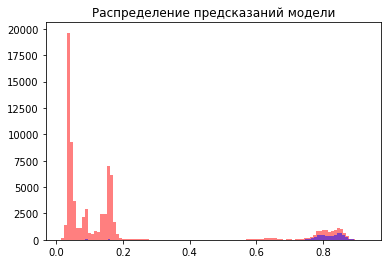

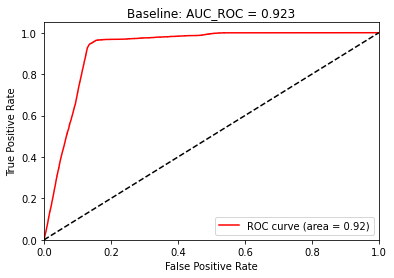

Normalized confusion matrix
[[0.84533989 0.15466011]
 [0.03744607 0.96255393]]


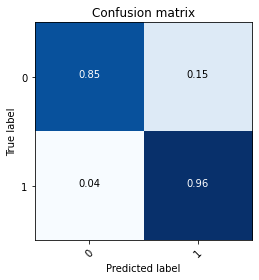

In [19]:
report(MODEL(**PARAMS), TRAIN, FIELDS)

# Сохраняем результат

In [0]:
md = trainModel(MODEL(**PARAMS), TRAIN, FIELDS)
TEST['target'] = md.predict_proba(TEST[FIELDS])[:,1]
result = TEST[['index', 'target']].set_index('index')

In [0]:
dms = pd.read_csv(PATH+'data_test.csv', sep=',', index_col=0)
dms['target'] = np.NaN
dms.update(result)
dms.to_csv(PATH+'answers_test.csv', sep=',')
dms['target'] = np.round(dms['target'])
dms.to_csv(PATH+'answers_test_class.csv', sep=',')